# LLM - Detect AI Generated Text


In [ ]:
!pip install -q keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install --upgrade -q wandb git+https://github.com/soumik12345/wandb-addons
!pip install TensorFlow==2.10.1
!pip install tensorflow-text==2.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 24.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-text
    Found existing installation: tensorflow-text 2.15.0
    Uninstalling tensorflow-text-2.15.0:
      Successfully uninstalled tensorflow-text-2.15.0


In [ ]:
#!pip install matplotlib

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch"  # "jax" or "tensorflow" or "torch"
os.environ['WANDB_NOTEBOOK_NAME'] = 'detect_fake_text_kerasnlp_tf_torch_jax_train.ipynb'
# os.environ["WANDB_SILENT"] = "false" # for wandb

import keras_nlp
import keras_core as keras
import keras_core.backend as K


import torch
# import jax
import tensorflow as tf
# from tensorflow import keras
# import tensorflow.keras.backend as K

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.colormaps.get_cmap('coolwarm')

Using PyTorch backend.


## Library Version

In [ ]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.10.1
Keras: 0.1.7
KerasNLP: 0.6.3


# Configuration

In [ ]:
class CFG:
    verbose = 0  # Verbosity

    wandb = True  # Weights & Biases logging
    competition = 'llm-detect-ai-generated-text'  # Competition name
    _wandb_kernel = 'awsaf49'  # WandB kernel
    comment = 'DebertaV3-MaxSeq_200-ext_s-torch'  # Comment description

    preset = "deberta_v3_base_en"  # Name of pretrained models
    sequence_length = 200  # Input sequence length

    device = 'TPU'  # Device

    seed = 42  # Random seed

    num_folds = 4  # Total folds
    selected_folds = [0, 1, 2]  # Folds to train on

    epochs = 3 # Training epochs
    batch_size = 16  # Batch size
    drop_remainder = True  # Drop incomplete batches
    cache = True # Caches data after one iteration, use only with `TPU` to avoid OOM
    replicas = 3

    scheduler = 'cosine'  # Learning rate scheduler

    class_names = ["real", "fake"]  # Class names [A, B, C, D, E]
    num_classes = len(class_names)  # Number of classes
    class_labels = list(range(num_classes))  # Class labels [0, 1, 2, 3, 4]
    label2name = dict(zip(class_labels, class_names))  # Label to class name mapping
    name2label = {v: k for k, v in label2name.items()}  # Class name to label mapping

In [ ]:
keras.utils.set_random_seed(CFG.seed)

# Hardware Setup
Following codes automatically detects hardware (TPU or GPU).

In [ ]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    try:
        # Connect to TPU
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print("All devices: ", tf.config.list_logical_devices('TPU'))
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(resolver)
        print(f'> Running on TPU', resolver.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device

In [ ]:
# Initialize GPU/TPU/TPU-VM
strategy, CFG.device = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on GPU | Num of GPUs:  1


# Dataset Path

In [ ]:
from google.colab import drive

In [ ]:
base_path = '/content/'

train_prompts_path = base_path + 'train_prompts.csv'
test_essays_path = base_path + 'test_essays.csv'
train_essays_path = base_path + 'train_essays.csv'
sample_submission_path = base_path + 'sample_submission.csv'

train_prompts_df = pd.read_csv(train_prompts_path)
test_essays_df = pd.read_csv(test_essays_path)
train_essays_df = pd.read_csv(train_essays_path)

# Meta Data
* `{test|train}_essays.csv`
    * `id` - A unique identifier for each essay.
    * `prompt_id` - Identifies the prompt the essay was written in response to.
    * `text` - The essay text itself.
    * `generated` - Whether the essay was written by a student (0) or generated by an LLM (1). This field is the target and is not present in test_essays.csv.

## Train Data

In [ ]:
train_essays_df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


# Train Data: 1,378
# Sample:


,id,prompt_id,text,generated,label,name
0,0059830c,0,Cars. Cars have been around since they became ...,0,0,real
1,005db917,0,Transportation is a large necessity in most co...,0,0,real


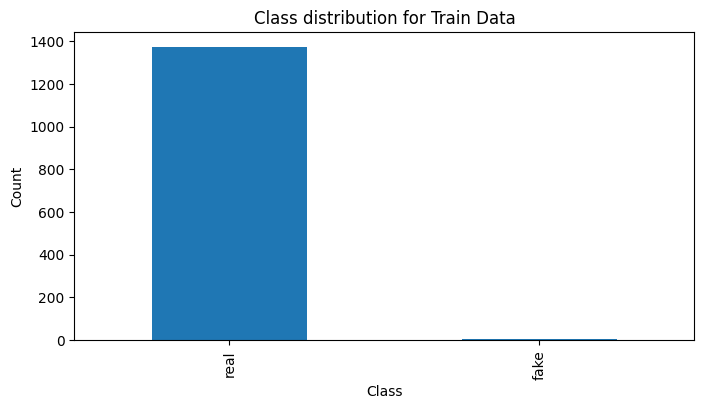

In [ ]:
# Copying the 'generated' column to a new 'label' column
train_essays_df['label'] = train_essays_df['generated'].copy()

# Mapping the labels to names using the CFG dictionary
train_essays_df['name'] = train_essays_df['generated'].map(CFG.label2name) #change later, switch numeric labels to class cateogories

# Displaying information about the train data
print("# Train Data: {:,}".format(len(train_essays_df)))
print("# Sample:")
display(train_essays_df.head(2))

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
train_essays_df['name'].value_counts().plot.bar()
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for Train Data")
plt.show()

This is too little data, and we need more!

## External Datasets

We'll be utilizing the following external datasets:

* [Augmented data for LLM - Detect AI Generated Text](https://www.kaggle.com/datasets/jdragonxherrera/augmented-data-for-llm-detect-ai-generated-text?select=final_train.csv) @jdragonxherrera




# External Data: 433,564
# Sample:


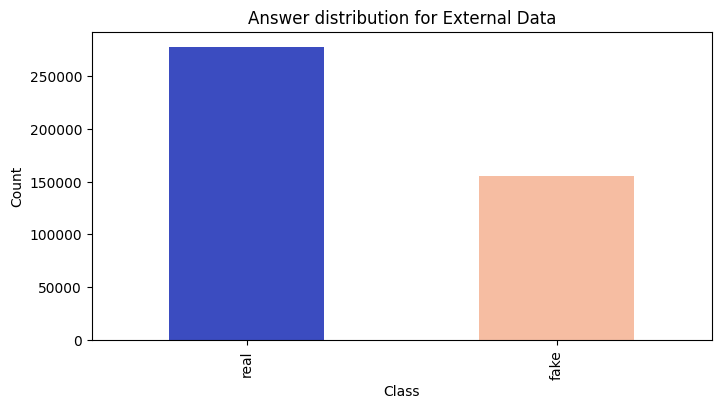

In [ ]:
file_names = ['final_train.csv', 'final_train2.csv']

ext_df = pd.concat([pd.read_csv(base_path + file) for file in file_names])
ext_df['name'] = ext_df.label.map(CFG.label2name)

print("# External Data: {:,}".format(len(ext_df)))
print("# Sample:")

plt.figure(figsize=(8, 4))
ext_df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.65)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Answer distribution for External Data")
plt.show()

In [ ]:
ext_df.head()

,text,label,name
0,We should keep the Electoral College for a num...,0,real
1,More and more money is spent on building theat...,1,fake
2,Limiting car usage can actually be effective b...,0,real
3,"Dear Mrs. Smith,\n\nI am writing to you today ...",1,fake
4,"Dear Principal,\n\nAfter school or during scho...",0,real


In [ ]:
len(ext_df[ext_df['label'] == 1])

155565

## Some More Balancing and Shrinking

In [ ]:
ext_df_final = pd.concat([ext_df[ext_df['label'] == 0].sample(20000), ext_df[ext_df['label'] == 1].sample(20000)]).reset_index(drop=True)

In [ ]:
len(ext_df_final[ext_df_final['label'] == 0])

20000

# External Data: 40,000
# Sample:


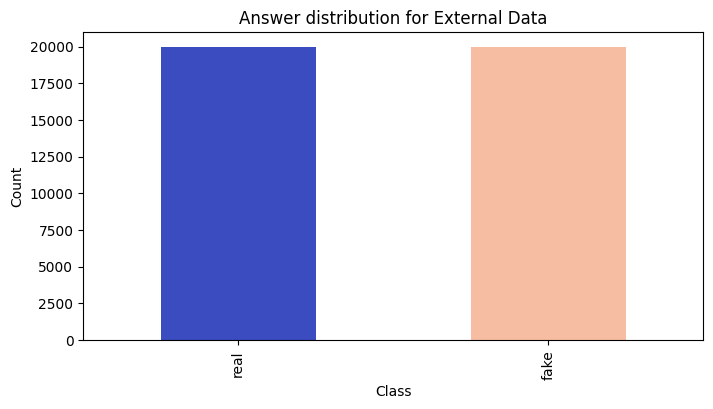

In [ ]:
print("# External Data: {:,}".format(len(ext_df_final)))
print("# Sample:")

plt.figure(figsize=(8, 4))
ext_df_final.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.65)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Answer distribution for External Data")
plt.show()

## Combine External and Train Data

In [ ]:
df = pd.concat([ext_df_final, train_essays_df], axis=0).reset_index(drop=True)

df.head()

,text,label,name,id,prompt_id,generated
0,It is necessary for a student to keep their mi...,0,real,NaN,NaN,NaN
1,"THC FACS, or Facial Action Coding System, can ...",0,real,NaN,NaN,NaN
2,I\n\nWould disagree for adding a one hour and ...,0,real,NaN,NaN,NaN
3,Have you ever wondered what it is like to have...,0,real,NaN,NaN,NaN
4,"Senator of Florida, YM writing you today to ad...",0,real,NaN,NaN,NaN


# Data Split

In the code snippet provided below, we will divide the existing **train** data into folds using a stratification of `label` column.

In [ ]:
df.head()

,text,label,name,id,prompt_id,generated
0,It is necessary for a student to keep their mi...,0,real,NaN,NaN,NaN
1,"THC FACS, or Facial Action Coding System, can ...",0,real,NaN,NaN,NaN
2,I\n\nWould disagree for adding a one hour and ...,0,real,NaN,NaN,NaN
3,Have you ever wondered what it is like to have...,0,real,NaN,NaN,NaN
4,"Senator of Florida, YM writing you today to ad...",0,real,NaN,NaN,NaN


In [ ]:
from sklearn.model_selection import StratifiedKFold  # Import package

skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)  # Initialize K-Fold

df = df.reset_index(drop=True)  # Reset dataframe index

df['stratify'] = df.label.astype(str)

df["fold"] = -1  # New 'fold' column

# Assign folds using StratifiedKFold
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['stratify'])):
    df.loc[val_idx, 'fold'] = fold

# Display label distribution for each fold
df.groupby(["fold", "name"]).size()

fold  name
0     fake    5001
      real    5344
1     fake    5001
      real    5344
2     fake    5000
      real    5344
3     fake    5001
      real    5343
dtype: int64

# Preprocessing

**What it does:** The preprocessor takes input strings and transforms them into a dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

In [ ]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

Now, let's examine what the output shape of the preprocessing layer looks like. The output shape of the layer can be represented as $(num\_choices, sequence\_length)$.

In [ ]:
inp = preprocessor(df.text.iloc[0])  # Process text for the first row

# Display the shape of each processed output
for k, v in inp.items():
    print(k, ":", v.shape)

token_ids : torch.Size([200])
padding_mask : torch.Size([200])


We'll use the `preprocessing_fn` function to transform each text option using the `dataset.map(preprocessing_fn)` method.

In [ ]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

# DataLoader

The code below sets up a robust data flow pipeline using `tf.data.Dataset` for data processing. Notable aspects of `tf.data` include its ability to simplify pipeline construction and represent components in sequences.


In [ ]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=False, drop_remainder=True,
                  repeat=False, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    ds = ds.repeat() if repeat else ds  # Repeat dataset if enabled
    opt = tf.data.Options()  # Create dataset options
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

## Fetch Train/Valid Dataset

The function below generates the training and validation datasets for a given fold.

In [ ]:
def get_datasets(fold):
    train_df = df[df.fold!=fold].sample(frac=1)  # Get training fold data

    train_texts = train_df.text.tolist()  # Extract training texts
    train_labels = train_df.label.tolist()  # Extract training labels

    # Build training dataset
    train_ds = build_dataset(train_texts, train_labels,
                             batch_size=CFG.batch_size*CFG.replicas, cache=CFG.cache,
                             shuffle=True, drop_remainder=True, repeat=True)

    valid_df = df[df.fold==fold].sample(frac=1)  # Get validation fold data
    valid_texts = valid_df.text.tolist()  # Extract validation texts
    valid_labels = valid_df.label.tolist()  # Extract validation labels

    # Build validation dataset
    valid_ds = build_dataset(valid_texts, valid_labels,
                             batch_size=min(CFG.batch_size*CFG.replicas, len(valid_df)), cache=CFG.cache,
                             shuffle=False, drop_remainder=True, repeat=False)

    return (train_ds, train_df), (valid_ds, valid_df)  # Return datasets and dataframes

# WandB

To monitor the training of my text-based model, I'll make use of **Weights & Biases**. Weights & Biases (W&B) is an MLOps platform that offers experiment tracking, dataset versioning, and model management functionalities, aiding in efficient model development.

In [ ]:
import wandb  # Import wandb library for experiment tracking
import wandb_addons # Additional wandb utilities

try:
    from kaggle_secrets import UserSecretsClient  # Import UserSecretsClient
    user_secrets = UserSecretsClient()  # Create secrets client instance
    api_key = user_secrets.get_secret("WANDB")  # Get API key from Kaggle secrets
    wandb.login(key=api_key)  # Login to wandb with the API key
    anonymous = 'allow'  # Set anonymous mode to None
except:
    anonymous = 'must'  # Set anonymous mode to 'must'
    wandb.login(anonymous=anonymous, relogin=True)  # Login to wandb anonymously and relogin if needed

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find detect_fake_text_kerasnlp_tf_torch_jax_train.ipynb.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Logger

The following code cell contains code to log data to WandB. It is noteworthy that the newly released callbacks offer more flexibility in terms of customization, and they are more compact compared to the classic `WandbCallback`, making it easier to use. Here's a brief introduction to them:

* **WandbModelCheckpoint**: This callback saves the model or weights using `tf.keras.callbacks.ModelCheckpoint`. Hence, we can harness the power of the official TensorFlow callback to log even `tf.keras.Model` subclass model in TPU.
* **WandbMetricsLogger**: This callback simply logs all the metrics and losses.
* **WandbEvalCallback**: This one is even more special. We can use it to log the model's prediction after a certain epoch/frequency. We can use it to save segmentation masks, bounding boxes, GradCAM within epochs to check intermediate results and so on.


In [ ]:

def wandb_init(fold):
    config = {k: v for k, v in dict(vars(CFG)).items() if '__' not in k}
    config.update({"fold": int(fold)})  # Add fold to config
    run = wandb.init(project="llm-fake-text",
                     name=f"fold-{fold}|max_seq-{CFG.sequence_length}|model-{CFG.preset}",
                     config=config,
                     group=CFG.comment,
                     save_code=True,
                     anonymous="allow")
    return run

def log_wandb():
    wandb.log({'best_auc': best_auc, 'best_loss': best_loss, 'best_epoch': best_epoch})

# Fetch W&B callbacks
def get_wb_callbacks(fold):
#     wb_ckpt = WandbModelCheckpoint(f'fold{fold}.keras',
#                                    monitor='val_auc',
#                                    save_best_only=True,
#                                    save_weights_only=False,
#                                    mode='max')
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_metr]  # Return WandB callbacks


# ⚓ | LR Schedule

Implementing a learning rate scheduler is crucial for transfer learning. The learning rate initiates at `lr_start` and gradually tapers down to `lr_min` using various techniques, including:
- `step`: Lowering the learning rate in step-wise manner resembling stairs.
- `cos`: Utilizing a cosine curve to gradually reduce the learning rate.
- `exp`: Exponentially decreasing the learning rate.

**Importance:** A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation. Initially, a smaller learning rate is often used to avoid large updates that could destroy the pre-learned features. Over time, adjusting the learning rate can help in finding an optimal set of weights for the new task.
A learning rate scheduler can be particularly useful when fine-tuning the last few layers of a large neural network while keeping the earlier layers fixed.

In [ ]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-6, 0.5e-6 * batch_size, 0.3e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 1, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

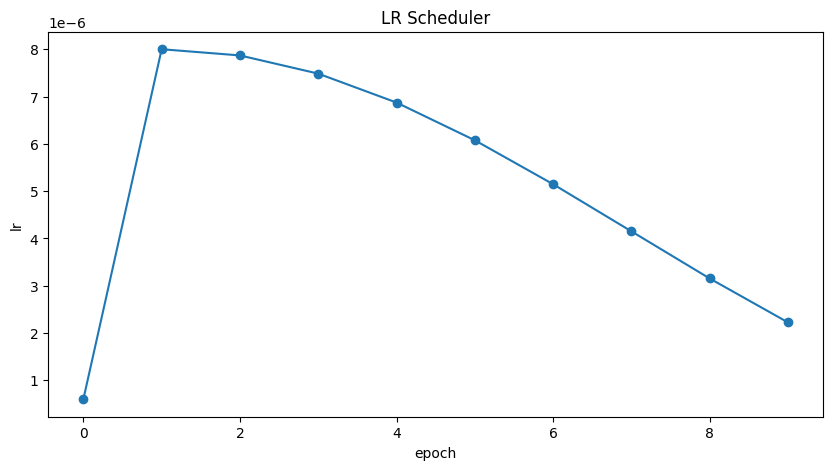

In [ ]:
_=get_lr_callback(CFG.batch_size*CFG.replicas, plot=True)

# Callbacks

The function below will gather all the training callbacks, such as `lr_scheduler`, `model_checkpoint`, `wandb_logger`, and etc.

In [ ]:
def get_callbacks(fold):
    callbacks = []
    lr_cb = get_lr_callback(CFG.batch_size*CFG.replicas)
    ckpt_cb = keras.callbacks.ModelCheckpoint(f'fold{fold}.keras',
                                              monitor='val_auc',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              mode='max')
    callbacks.extend([lr_cb, ckpt_cb])

    if CFG.wandb:
        wb_cbs = get_wb_callbacks(fold)  # Get WandB callbacks
        callbacks.extend(wb_cbs)

    return callbacks  # Return the list of callbacks

# Modeling



## KerasNLP Classifier

The `KerasNLP` library provides comprehensive, ready-to-use implementations of popular NLP model architectures. It features a variety of pre-trained models including `Bert`, `Roberta`, `DebertaV3`, and more. In this notebook, we'll showcase the usage of `DebertaV3`.

Our approach involves using `keras_nlp.models.XXClassifier` to process each text and generatie logits. These logits are passed through a `softmax` function to produce the final output.

In [ ]:
def build_model():
    # Create a DebertaV3Classifier model
    classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
        CFG.preset,
        preprocessor=None,
        num_classes=1 # one output per one option, for five options total 5 outputs
    )
    inputs = classifier.input
    logits = classifier(inputs)

    outputs = keras.layers.Activation("sigmoid")(logits)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.AdamW(3e-6),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.01),
        metrics=[
            keras.metrics.AUC(name="auc"),
        ],
        jit_compile=True
    )
    return model

In [ ]:
model = build_model()

/usr/local/lib/python3.10/dist-packages/keras_core/src/trainers/trainer.py:166: UserWarning: `jit_compile` is not yet enabled for the PyTorch backend. Proceeding with `jit_compile=False`.
  warnings.warn(


### Model Summary

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, None)           │          0 │ -                          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ token_ids (InputLayer)    │ (None, None)           │          0 │ -                          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ deberta_v3_classifier     │ (None, 1)              │ 184,422,9… │ padding_mask[0][0],        │
│ (DebertaV3Classifier)     │                        │            │ token_ids[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ activation (Activation)   │ (None, 1)              │          0 │ deberta_v3_classifier[0][… │
└───────────────────────────┴────────────────────────┴────────────┴────────────────────────────┘

 Total params: 184,422,913 (703.52 MB)

 Trainable params: 184,422,913 (703.52 MB)

 Non-trainable params: 0 (0.00 B)

### Model Plot

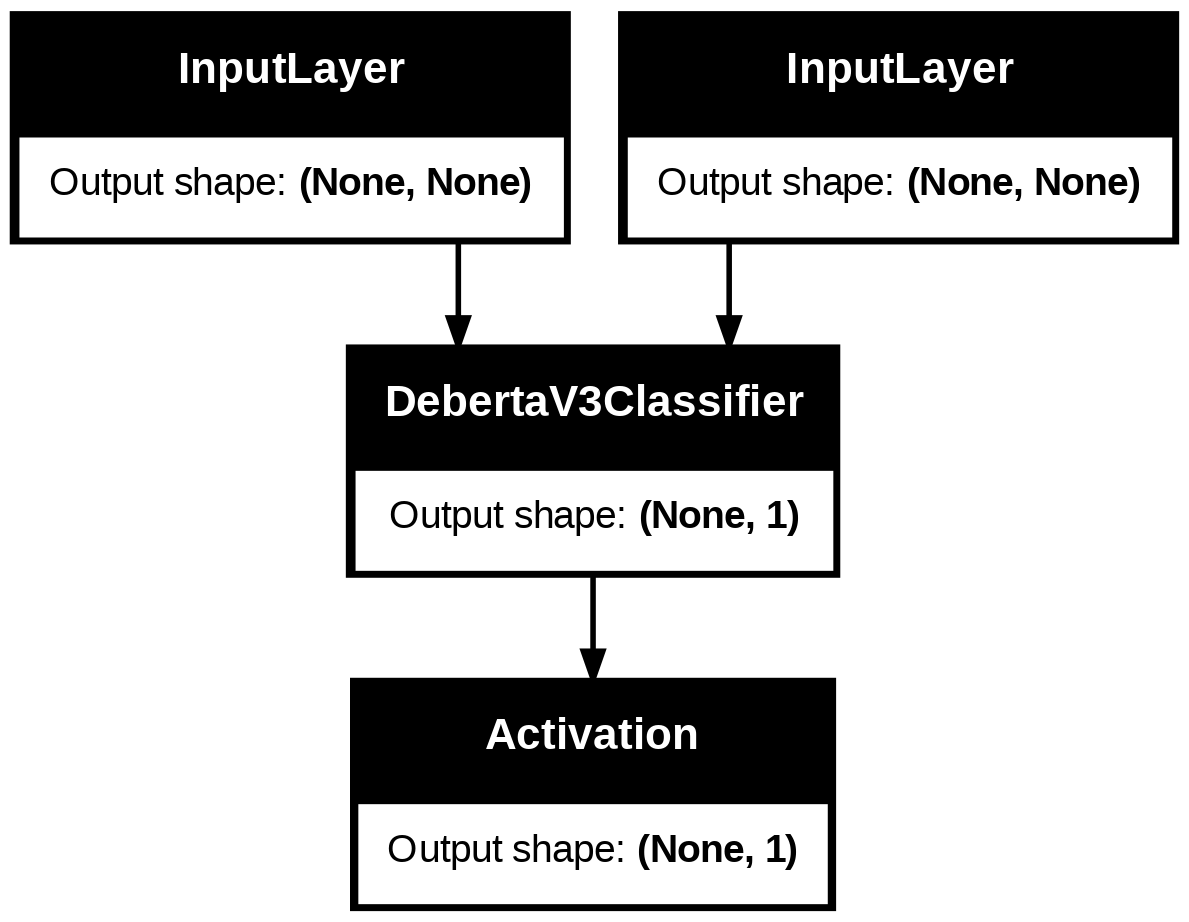

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

# Training

In [ ]:
for fold in CFG.selected_folds:
    if CFG.wandb:
        run = wandb_init(fold)

    (train_ds, train_df), (valid_ds, valid_df) = get_datasets(fold)
    callbacks = get_callbacks(fold)

    print('#' * 50)
    print(f'\tFold: {fold + 1} | Model: {CFG.preset}\n\tBatch Size: {CFG.batch_size * CFG.replicas} | Scheduler: {CFG.scheduler}')
    print(f'\tNum Train: {len(train_df)} | Num Valid: {len(valid_df)}')
    print('#' * 50)

    K.clear_session()
    with strategy.scope():
        model = build_model()

    history = model.fit(
        train_ds,
        epochs=CFG.epochs,
        validation_data=valid_ds,
        callbacks=callbacks,
        steps_per_epoch=int(len(train_df) / CFG.batch_size / CFG.replicas),
    )

    best_epoch = np.argmax(model.history.history['val_auc'])
    best_auc = model.history.history['val_auc'][best_epoch]
    best_loss = model.history.history['val_loss'][best_epoch]

    print(f'\n{"=" * 17} FOLD {fold} RESULTS {"=" * 17}')
    print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST AUC   : {best_auc:.3f}\n>>>> BEST Epoch : {best_epoch}')
    print('=' * 50)

    if CFG.wandb:
        log_wandb()
        wandb.run.finish()
    print("\n\n")

wandb: Currently logged in as: daniel-zhijin-fang (aitext). Use `wandb login --relogin` to force relogin


##################################################
	Fold: 1 | Model: deberta_v3_base_en
	Batch Size: 16 | Scheduler: cosine
	Num Train: 31033 | Num Valid: 10345
##################################################
Epoch 1/3
1939/1939 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - auc: 0.8873 - loss: 0.3814

wandb: ERROR Unable to log learning rate.


1939/1939 ━━━━━━━━━━━━━━━━━━━━ 822s 424ms/step - auc: 0.8873 - loss: 0.3813 - val_auc: 0.9978 - val_loss: 0.0830 - learning_rate: 6.0000e-07
Epoch 2/3
1939/1939 ━━━━━━━━━━━━━━━━━━━━ 829s 428ms/step - auc: 0.9978 - loss: 0.0697 - val_auc: 0.9991 - val_loss: 0.0511 - learning_rate: 8.0000e-06
Epoch 3/3
1939/1939 ━━━━━━━━━━━━━━━━━━━━ 816s 421ms/step - auc: 0.9992 - loss: 0.0430 - val_auc: 0.9990 - val_loss: 0.0484 - learning_rate: 7.8688e-06

================= FOLD 0 RESULTS =================
>>>> BEST Loss  : 0.051
>>>> BEST AUC   : 0.999
>>>> BEST Epoch : 1


best_auc,▁
best_epoch,▁
best_loss,▁
epoch/auc,▁██
epoch/epoch,▁▅█
epoch/learning_rate,▁██
epoch/loss,█▂▁
epoch/val_auc,▁█▇
epoch/val_loss,█▂▁
best_auc,0.99911
best_epoch,1


##################################################
	Fold: 2 | Model: deberta_v3_base_en
	Batch Size: 16 | Scheduler: cosine
	Num Train: 31033 | Num Valid: 10345
##################################################


/usr/local/lib/python3.10/dist-packages/keras_core/src/trainers/trainer.py:166: UserWarning: `jit_compile` is not yet enabled for the PyTorch backend. Proceeding with `jit_compile=False`.
  warnings.warn(


Epoch 1/3
1939/1939 ━━━━━━━━━━━━━━━━━━━━ 828s 427ms/step - auc: 0.8984 - loss: 0.3940 - val_auc: 0.9984 - val_loss: 0.0893 - learning_rate: 6.0000e-07
Epoch 2/3
1939/1939 ━━━━━━━━━━━━━━━━━━━━ 830s 428ms/step - auc: 0.9979 - loss: 0.0661 - val_auc: 0.9994 - val_loss: 0.0499 - learning_rate: 8.0000e-06
Epoch 3/3
1939/1939 ━━━━━━━━━━━━━━━━━━━━ 829s 428ms/step - auc: 0.9994 - loss: 0.0415 - val_auc: 0.9998 - val_loss: 0.0436 - learning_rate: 7.8688e-06

================= FOLD 1 RESULTS =================
>>>> BEST Loss  : 0.044
>>>> BEST AUC   : 1.000
>>>> BEST Epoch : 2


best_auc,▁
best_epoch,▁
best_loss,▁
epoch/auc,▁██
epoch/epoch,▁▅█
epoch/learning_rate,▁██
epoch/loss,█▂▁
epoch/val_auc,▁▆█
epoch/val_loss,█▂▁
best_auc,0.99982
best_epoch,2


##################################################
	Fold: 3 | Model: deberta_v3_base_en
	Batch Size: 16 | Scheduler: cosine
	Num Train: 31034 | Num Valid: 10344
##################################################
Epoch 1/3
1939/1939 ━━━━━━━━━━━━━━━━━━━━ 826s 426ms/step - auc: 0.8462 - loss: 0.4372 - val_auc: 0.9983 - val_loss: 0.0884 - learning_rate: 6.0000e-07
Epoch 2/3
1939/1939 ━━━━━━━━━━━━━━━━━━━━ 833s 430ms/step - auc: 0.9980 - loss: 0.0657 - val_auc: 0.9987 - val_loss: 0.0719 - learning_rate: 8.0000e-06
Epoch 3/3
1939/1939 ━━━━━━━━━━━━━━━━━━━━ 834s 430ms/step - auc: 0.9996 - loss: 0.0430 - val_auc: 0.9993 - val_loss: 0.0563 - learning_rate: 7.8688e-06

================= FOLD 2 RESULTS =================
>>>> BEST Loss  : 0.056
>>>> BEST AUC   : 0.999
>>>> BEST Epoch : 2


best_auc,▁
best_epoch,▁
best_loss,▁
epoch/auc,▁██
epoch/epoch,▁▅█
epoch/learning_rate,▁██
epoch/loss,█▂▁
epoch/val_auc,▁▄█
epoch/val_loss,█▄▁
best_auc,0.99934
best_epoch,2


## Training Log
### [Click Here ➡️](https://wandb.ai/awsaf49/llm-fake-text) to check all the training logs in **WandB** dashboard.

![image.png](attachment:4164c26d-d907-45db-9df9-93d90713d784.png)

# 🧪 | Prediction

In [ ]:
# Make predictions using the trained model on last validation data
predictions = model.predict(
    valid_ds,
    batch_size=min(CFG.batch_size * CFG.replicas * 2, len(valid_df)), # max batch size = valid size
    verbose=1
)

646/646 ━━━━━━━━━━━━━━━━━━━━ 93s 144ms/step


In [ ]:
# Format predictions and true answers
pred_answers = (predictions > 0.5).astype(int).squeeze()
true_answers = valid_df.label.values

# Check 5 Predictions
print("# Predictions\n")
for i in range(5):
    row = valid_df.iloc[i]
    text  = row.text
    pred_answer = CFG.label2name[pred_answers[i]]
    true_answer = CFG.label2name[true_answers[i]]
    print(f"Text {i+1}:\n{text[:100]} .... {text[-100:]}\n")
    print(f"True: {true_answer}\n")
    print(f"Predicted: {pred_answer}\n")
    print("-"*90, "\n")

# Predictions

Text 1:
Have you ever wanted to be apart of NASA or a scientist? Scientist get to explore many parts of the  .... eryone would not be satisfied with my agreement, I now have proof that it was not created by aliens.

True: real

Predicted: real

------------------------------------------------------------------------------------------ 

Text 2:
Every dry, people make decisions about their lives and futures, sometimes without seeking expert gui .... d cons. Each individual must weigh the merits and demerits and arrive rt the best possible solution.

True: fake

Predicted: fake

------------------------------------------------------------------------------------------ 

Text 3:
I strongly disagree with the principal's decision to make extracurricular activities mandatory. Whil .... happy BND engaged in their extracurricular activities, rather then feeling obligated to participate.

True: fake

Predicted: fake

----------------------------------------------------------------